In [31]:
import pandas as pd
import numpy as np
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization, ZeroPadding2D
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from tensorflow import keras

warnings.filterwarnings('ignore')

In [32]:
df = pd.read_csv('all_data.csv').sample(frac=1).reset_index(drop=True)[:200000]
df = df.replace([np.inf, -np.inf], np.nan).dropna()

In [33]:
df.shape

(200000, 79)

In [34]:
# Print all column names
print(df.info)

<bound method DataFrame.info of         Destination Port  Flow Duration  Total Fwd Packets  \
0                    443           9610                  2   
1                     53          48337                  2   
2                   7777             48                  1   
3                  60323             31                  1   
4                     53          47969                  2   
...                  ...            ...                ...   
199995               443        4464408                  5   
199996               443        5912987                  9   
199997                53            197                  2   
199998                80          11007                  3   
199999                53        1161820                  3   

        Total Backward Packets  Total Length of Fwd Packets  \
0                            0                           12   
1                            2                           80   
2                            1    

In [35]:
df["Label"].value_counts()
df['Label'] = df['Label'].replace('ï¿½,¿½', '-', regex=True)

In [36]:
df["Label"].value_counts()

Label
BENIGN                          160698
DoS Hulk                         16233
PortScan                         11344
DDoS                              8968
DoS GoldenEye                      689
FTP-Patator                        554
DoS slowloris                      428
SSH-Patator                        394
DoS Slowhttptest                   380
Bot                                151
Web Attack -¿½ Brute Force         108
Web Attack -¿½ XSS                  43
Infiltration                         6
Heartbleed                           2
Web Attack -¿½ Sql Injection         2
Name: count, dtype: int64

In [37]:
cl = len(df["Label"].value_counts())
cl

15

In [38]:
# Define the minority and majority classes
minority_class = ['Web Attack  Sql Injection', 'Infiltration', 'Web Attack  XSS']
majority_class = ['BENIGN', 'DoS Hulk', 'DDoS', 'PortScan', 'Web Attack  Brute Force', 'Bot', 'DoS Slowhttptest', 'DoS slowloris', 'FTP-Patator', 'SSH-Patator', 'DoS GoldenEye']

# Split the dataset into minority and majority
minority = df[df['Label'].isin(minority_class)].reset_index(drop=True)
majority = df[df['Label'].isin(majority_class)].reset_index(drop=True)

In [39]:
enn = NearestNeighbors(n_neighbors=500)
enn.fit(majority.drop(columns=['Label']))
difficult_idx = enn.kneighbors(minority.drop(columns=['Label']), return_distance=False).flatten()
difficult = df.iloc[difficult_idx]
easy = df.reset_index(drop=True).drop(difficult_idx)

In [40]:
difficult["Label"].value_counts()

Label
BENIGN                        2428
DoS Hulk                       238
PortScan                       169
DDoS                           123
FTP-Patator                     12
DoS Slowhttptest                 7
DoS GoldenEye                    7
SSH-Patator                      7
DoS slowloris                    6
Web Attack -¿½ Brute Force       2
Bot                              1
Name: count, dtype: int64

In [41]:
easy["Label"].value_counts()

Label
BENIGN                          158709
DoS Hulk                         16039
PortScan                         11205
DDoS                              8861
DoS GoldenEye                      683
FTP-Patator                        544
DoS slowloris                      423
SSH-Patator                        387
DoS Slowhttptest                   374
Bot                                150
Web Attack -¿½ Brute Force         107
Web Attack -¿½ XSS                  43
Infiltration                         6
Heartbleed                           2
Web Attack -¿½ Sql Injection         2
Name: count, dtype: int64

In [42]:
# Use KMeans to compress majority samples in the difficult set
kmeans = KMeans(n_clusters=100)
kmeans.fit(difficult.drop(columns=['Label']))
compressed = pd.DataFrame(kmeans.cluster_centers_, columns=difficult.columns[:-1])
compressed['Label'] = 'BENIGN'

In [43]:
# Generate synthetic minority samples in the difficult set
difficult_min = difficult[difficult['Label'].isin(minority_class)]
difficult_max = difficult[difficult['Label'] == 'BENIGN']
difficult_range = difficult_max - difficult_min
difficult_samples = pd.DataFrame()

In [44]:
for i in range(10):
  r = pd.DataFrame(columns=difficult_min.columns[:-1])
  random_values = np.random.rand(difficult_min.shape[1]-1)
  r.loc[0] = random_values
  dm = difficult_min.iloc[:,:-1]
  sample = dm.add(r, fill_value=0)
  sample['Label'] = minority_class[np.random.randint(0, len(minority_class))]
  difficult_samples = pd.concat([difficult_samples, sample], ignore_index=True)

In [45]:
new_train_set = pd.concat([easy, compressed, difficult_min, difficult_samples])
df2 = new_train_set.sample(frac=1).reset_index(drop=True)

In [46]:
df2

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,80.0,50064.0,1.0,1.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,32.0,0.000000,0.000000,0.0,0.0,0.000000e+00,0.000000,0.0,0.0,BENIGN
1,80.0,99506990.0,6.0,8.0,359.0,11595.0,341.0,0.0,59.833333,137.774332,...,20.0,13991.000000,0.000000,13991.0,13991.0,9.940000e+07,0.000000,99400000.0,99400000.0,DoS Hulk
2,80.0,82665360.0,8.0,7.0,706.0,11595.0,341.0,0.0,88.250000,156.022663,...,20.0,16039.000000,0.000000,16039.0,16039.0,8.230000e+07,0.000000,82300000.0,82300000.0,DoS Hulk
3,443.0,116010201.0,24.0,20.0,4178.0,4553.0,3573.0,0.0,174.083333,728.395552,...,32.0,155171.454545,302580.787887,1043030.0,42792.0,1.000292e+07,15982.749484,10028948.0,9959968.0,BENIGN
4,6669.0,81.0,1.0,1.0,0.0,6.0,0.0,0.0,0.000000,0.000000,...,40.0,0.000000,0.000000,0.0,0.0,0.000000e+00,0.000000,0.0,0.0,PortScan
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
197640,3476.0,45.0,1.0,1.0,2.0,6.0,2.0,2.0,2.000000,0.000000,...,24.0,0.000000,0.000000,0.0,0.0,0.000000e+00,0.000000,0.0,0.0,PortScan
197641,443.0,4819430.0,14.0,9.0,2681.0,8057.0,777.0,0.0,191.500000,322.057747,...,20.0,0.000000,0.000000,0.0,0.0,0.000000e+00,0.000000,0.0,0.0,BENIGN
197642,443.0,117951308.0,16.0,16.0,1080.0,5122.0,416.0,0.0,67.500000,109.397745,...,20.0,207576.000000,172242.726600,329370.0,85782.0,5.870000e+07,304391.791600,58900000.0,58500000.0,BENIGN
197643,53.0,189.0,2.0,2.0,68.0,182.0,34.0,34.0,34.000000,0.000000,...,20.0,0.000000,0.000000,0.0,0.0,0.000000e+00,0.000000,0.0,0.0,BENIGN


In [17]:
df2["Label"].value_counts()
df2['Label'] = df2['Label'].replace('ï¿½', '-', regex=True)

In [18]:
X_train, X_test, y_train, y_test = train_test_split(df2.iloc[:,:-1], df2.iloc[:,-1], test_size=0.3, random_state=42)

In [19]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train1 = X_train
X_test1 = X_test

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [20]:
from sklearn.preprocessing import LabelEncoder

# Assuming y_train and y_test are defined

# Create a label encoder
le = LabelEncoder()

# Fit the label encoder on the combined labels of both training and test sets
le.fit(list(y_train) + list(y_test))

# Transform labels in both training and test sets
y_train_encoded = le.transform(y_train)
y_test_encoded = le.transform(y_test)


In [21]:
print("Size of X_train:", X_train.size)

Size of X_train: 10851516


In [22]:
unique_labels = le.transform(df2['Label'].unique())

In [23]:
print(unique_labels)

[ 0  4  2  5 10 12  7  3  9  6 11  1 14  8 16 13 15]


In [24]:
# Combine y_train and y_test for consistent label encoding
all_labels = np.concatenate([y_train, y_test])

# Use LabelEncoder on the combined labels
le = LabelEncoder()
all_labels_encoded = le.fit_transform(all_labels)

# Split back into training and testing sets
y_train_encoded = all_labels_encoded[:len(y_train)]
y_test_encoded = all_labels_encoded[len(y_train):]

In [25]:
# Ensure X_train and X_test have the correct shapes
# Assuming X_train and X_test are numpy arrays
# Reshape X_train and X_test based on their original shapes
X1_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X1_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

Best Parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 1, 'subsample': 0.8}
[0]	validation_0-merror:0.02433	validation_0-mlogloss:2.06731	validation_1-merror:0.07918	validation_1-mlogloss:2.11293
[1]	validation_0-merror:0.02404	validation_0-mlogloss:1.72948	validation_1-merror:0.07706	validation_1-mlogloss:1.80020
[2]	validation_0-merror:0.01990	validation_0-mlogloss:1.49188	validation_1-merror:0.07609	validation_1-mlogloss:1.58174
[3]	validation_0-merror:0.01982	validation_0-mlogloss:1.30482	validation_1-merror:0.07606	validation_1-mlogloss:1.40986
[4]	validation_0-merror:0.01958	validation_0-mlogloss:1.15528	validation_1-merror:0.07582	validation_1-mlogloss:1.27383
[5]	validation_0-merror:0.01956	validation_0-mlogloss:1.03004	validation_1-merror:0.07584	validation_1-mlogloss:1.16073
[6]	validation_0-merror:0.01853	validation_0-mlogloss:0.92259	validation_1-merror:0.07579	validation_1-mlogloss:1.06405
[7]	validation_0-merror:0.

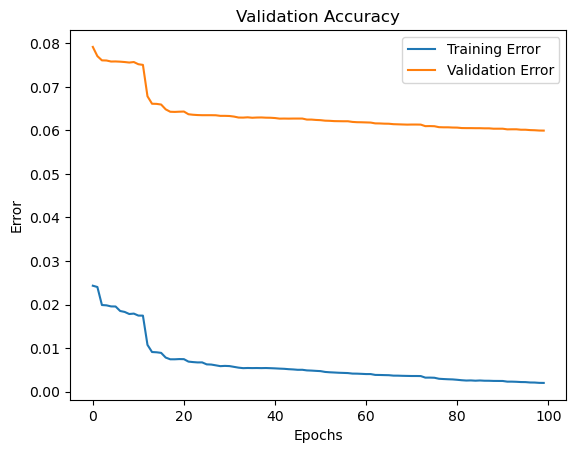

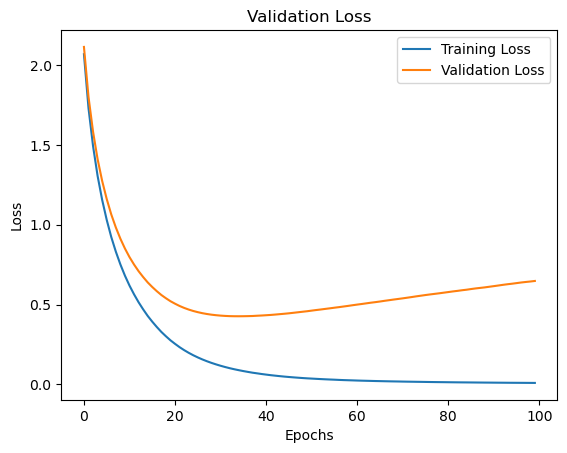

In [30]:
import xgboost as xgb
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV

# Assuming X_train, X_test, y_train, y_test are defined

# Use LabelEncoder separately for training and testing sets
le_train = LabelEncoder()
le_test = LabelEncoder()

# Fit LabelEncoder on training and testing labels separately
y_train_encoded = le_train.fit_transform(y_train)
y_test_encoded = le_test.fit_transform(y_test)

# XGBoost model
model = xgb.XGBClassifier(objective='multi:softmax', num_class=len(np.unique(y_train_encoded)))

# Grid search for hyperparameter tuning
param_grid = {
    'learning_rate': [0.1, 0.01],
    'max_depth': [3, 5, 7],
    'min_child_weight': [1, 3, 5],
    'gamma': [0, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train_encoded)

# Best parameters
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

# Train the model with best parameters and provide eval_set for validation
best_model = grid_search.best_estimator_
best_model.fit(X_train, y_train_encoded, eval_set=[(X_train, y_train_encoded), (X_test, y_test_encoded)], 
               eval_metric=['merror', 'mlogloss'], verbose=True)

# Make predictions
y_pred = best_model.predict(X_test)

# Classification report
classification_rep = classification_report(y_test_encoded, y_pred, labels=np.unique(y_test_encoded),
                                           target_names=le_test.classes_)
print("Classification Report:\n", classification_rep)

# Accuracy
accuracy = accuracy_score(y_test_encoded, y_pred)
print("\nAccuracy: %.2f%%" % (accuracy * 100))

# F1 score, precision, and recall
f1 = f1_score(y_test_encoded, y_pred, average='weighted')
precision = precision_score(y_test_encoded, y_pred, average='weighted')
recall = recall_score(y_test_encoded, y_pred, average='weighted')

print("F1 Score: %.2f" % f1)
print("Precision: %.2f" % precision)
print("Recall: %.2f" % recall)

# Plot validation accuracy and loss
results = best_model.evals_result()
plt.plot(results['validation_0']['merror'], label='Training Error')
plt.plot(results['validation_1']['merror'], label='Validation Error')
plt.title('Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Error')
plt.legend()
plt.show()

plt.plot(results['validation_0']['mlogloss'], label='Training Loss')
plt.plot(results['validation_1']['mlogloss'], label='Validation Loss')
plt.title('Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()




Epoch 1/10


4366/4367 [============================>.] - ETA: 0s - loss: 0.5769 - accuracy: 0.8524
Epoch 1: val_accuracy improved from -inf to 0.89758, saving model to best_model.h5
4367/4367 [==============================] - 242s 54ms/step - loss: 0.5768 - accuracy: 0.8525 - val_loss: 0.2917 - val_accuracy: 0.8976
Epoch 2/10
4366/4367 [============================>.] - ETA: 0s - loss: 0.4160 - accuracy: 0.8803
Epoch 2: val_accuracy improved from 0.89758 to 0.92455, saving model to best_model.h5
4367/4367 [==============================] - 235s 54ms/step - loss: 0.4160 - accuracy: 0.8803 - val_loss: 0.2530 - val_accuracy: 0.9246
Epoch 3/10
4366/4367 [============================>.] - ETA: 0s - loss: 0.3156 - accuracy: 0.9025
Epoch 3: val_accuracy did not improve from 0.92455
4367/4367 [==============================] - 235s 54ms/step - loss: 0.3156 - accuracy: 0.9025 - val_loss: 0.2395 - val_accuracy: 0.9224
Epoch 4/10
4367/4367 [==============================] - ETA: 0s - loss: 0.

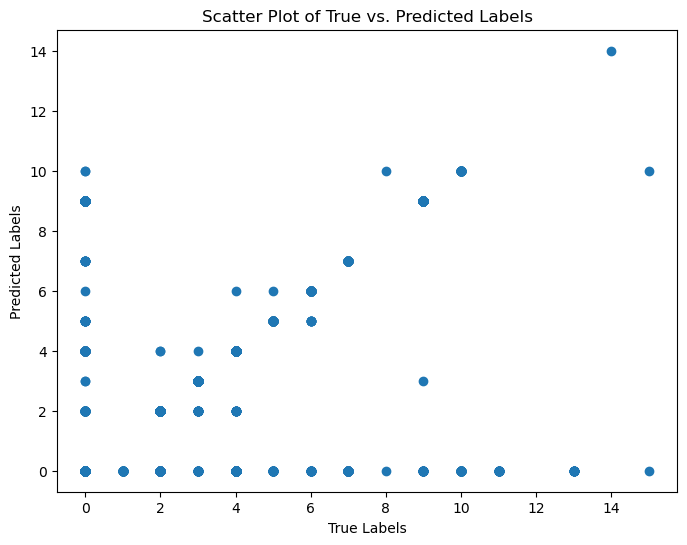

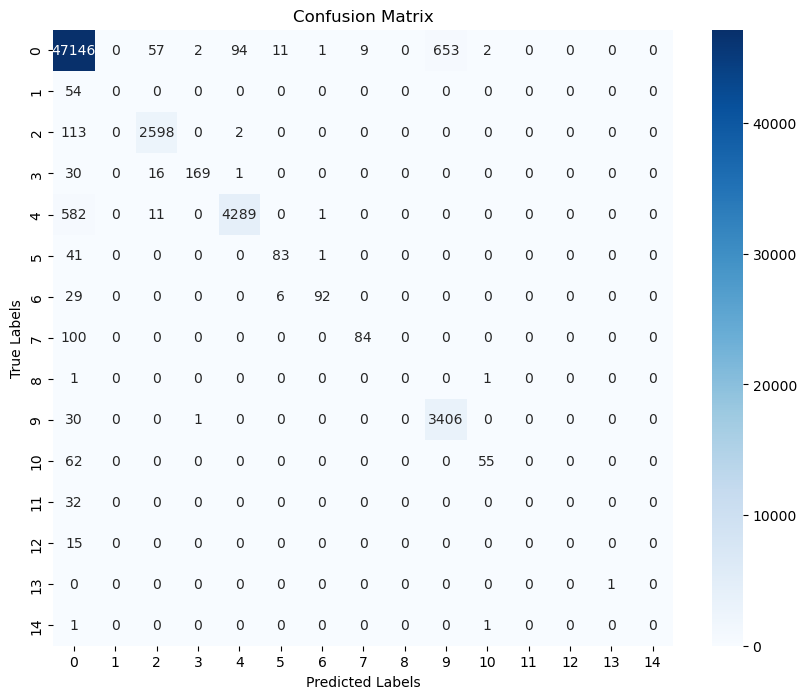

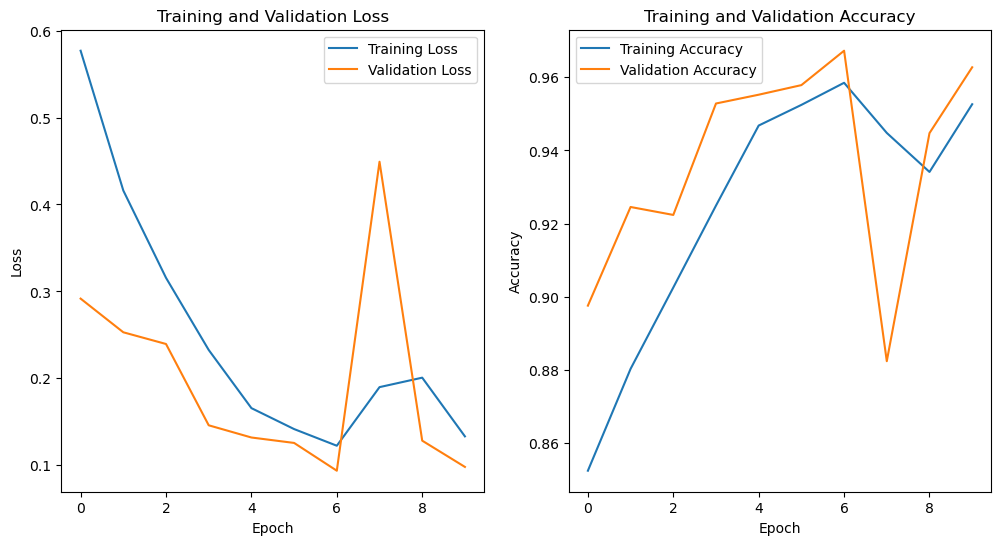

Best Validation Accuracy: 0.9673 at epoch 7


In [27]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense, LeakyReLU
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
import numpy as np
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from tensorflow.keras.callbacks import ModelCheckpoint

# Assuming X_train, X_test, y_train, y_test are defined

# Combine y_train and y_test for consistent label encoding
all_labels = np.concatenate([y_train, y_test])

# Use LabelEncoder on the combined labels
le = LabelEncoder()
all_labels_encoded = le.fit_transform(all_labels)

# Split back into training and testing sets
y_train_encoded = all_labels_encoded[:len(y_train)]
y_test_encoded = all_labels_encoded[len(y_train):]

# Ensure X_train and X_test have the correct shapes
# Assuming X_train and X_test are numpy arrays
# Reshape X_train and X_test based on their original shapes
X1_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X1_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

num_classes = len(np.unique(all_labels_encoded))

# LSTM model
model = Sequential()
model.add(LSTM(128, input_shape=(X1_train.shape[1], X1_train.shape[2]), activation='tanh', return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64, activation='tanh'))
model.add(Dropout(0.2))
model.add(Dense(32, activation=LeakyReLU(alpha=0.3)))
model.add(Dropout(0.2))
model.add(Dense(num_classes, activation='softmax'))

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Define the checkpoint path
checkpoint_path = "best_model.h5"

# Define the ModelCheckpoint callback to save the best model based on validation accuracy
checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

# Train the model with the checkpoint callback
history = model.fit(X1_train, y_train_encoded, epochs=10, validation_data=(X1_test, y_test_encoded), callbacks=[checkpoint])

# Load the best model
model.load_weights(checkpoint_path)

# Make predictions
y_pred_prob = model.predict(X1_test)
y_pred = np.argmax(y_pred_prob, axis=1)

# Ensure predicted labels are within the valid range
y_pred = np.clip(y_pred, 0, num_classes - 1)

# Classification report
classification_rep = classification_report(y_test_encoded, y_pred, labels=np.unique(y_test_encoded),
                                          target_names=[str(i) for i in range(num_classes)])
print("Classification Report:\n", classification_rep)

# Accuracy
accuracy = accuracy_score(y_test_encoded, y_pred)
print("\nAccuracy: %.2f%%" % (accuracy * 100))

# F1 score, precision, and recall
f1 = f1_score(y_test_encoded, y_pred, average='weighted')
precision = precision_score(y_test_encoded, y_pred, average='weighted')
recall = recall_score(y_test_encoded, y_pred, average='weighted')

print("F1 Score: %.2f" % f1)
print("Precision: %.2f" % precision)
print("Recall: %.2f" % recall)

# Scatter Plot
plt.figure(figsize=(8, 6))
plt.scatter(y_test_encoded, y_pred)
plt.xlabel('True Labels')
plt.ylabel('Predicted Labels')
plt.title('Scatter Plot of True vs. Predicted Labels')
plt.show()

# Confusion Matrix
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_test_encoded, y_pred)
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Loss and accuracy plots
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

# Print best parameters
best_val_accuracy = max(history.history['val_accuracy'])
best_epoch = history.history['val_accuracy'].index(best_val_accuracy) + 1
print(f"Best Validation Accuracy: {best_val_accuracy:.4f} at epoch {best_epoch}")


In [30]:
print("Size of X_test:", X_test.size)

Size of X_test: 4659174


In [31]:
# Print the size and shape of X_train and X_test
print("Size of X_train:", X_train.size)
print("Shape of X_train:", X_train.shape)

# Print the size and shape of X_test
print("Size of X_test:", X_test.size)
print("Shape of X_test:", X_test.shape)

Size of X_train: 10871406
Shape of X_train: (139377, 78)
Size of X_test: 4659174
Shape of X_test: (59733, 78)


In [26]:
X_train_reshaped = X_train.reshape((X_train.shape[0], 78, 1, 1))
X_test_reshaped = X_test.reshape((X_test.shape[0], 78, 1, 1))


Epoch 1/2
4348/4348 [==============================] - ETA: 0s - loss: 0.2599 - accuracy: 0.9342
Epoch 1: val_accuracy improved from -inf to 0.88637, saving model to best_model.h5
4348/4348 [==============================] - 1022s 234ms/step - loss: 0.2599 - accuracy: 0.9342 - val_loss: 0.8673 - val_accuracy: 0.8864
Epoch 2/2
4348/4348 [==============================] - ETA: 0s - loss: 0.1693 - accuracy: 0.9492
Epoch 2: val_accuracy improved from 0.88637 to 0.90662, saving model to best_model.h5
4348/4348 [==============================] - 1046s 241ms/step - loss: 0.1693 - accuracy: 0.9492 - val_loss: 1.3719 - val_accuracy: 0.9066


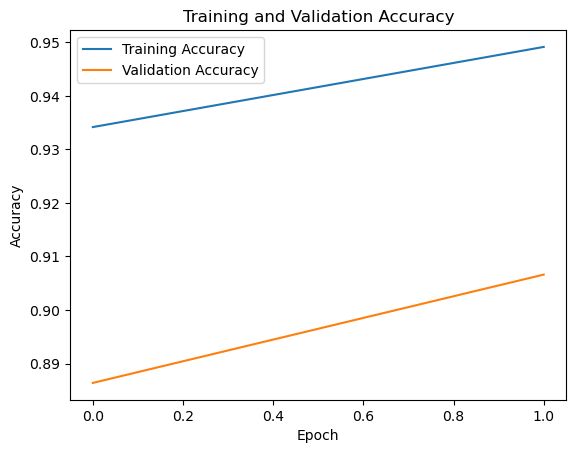

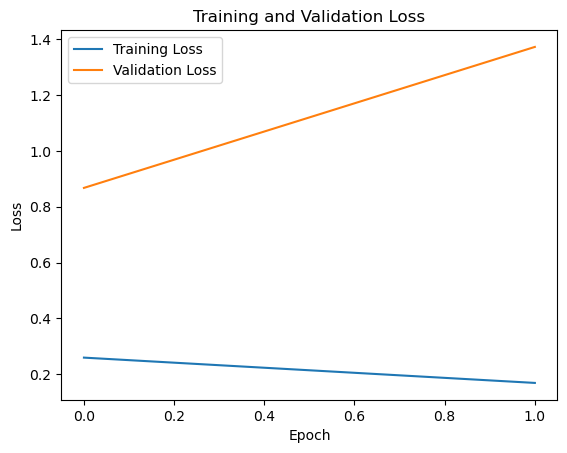

1864/1864 [==============================] - 27s 14ms/step - loss: 1.3719 - accuracy: 0.9066


Accuracy: 90.66%
1864/1864 [==============================] - 27s 14ms/step
F1 Score: 0.9103
Precision: 0.9151
Recall: 0.9066


In [47]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, precision_score, recall_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint

# Assuming X_train_reshaped, X_test_reshaped, y_train_encoded, y_test_encoded, num_classes are defined

# Define the model
model = Sequential()
model.add(Conv2D(filters=96, kernel_size=(78, 1), strides=(4, 4), activation='relu', input_shape=(78, 1, 1)))
model.add(MaxPooling2D(pool_size=(1, 1), strides=(1, 1)))
model.add(BatchNormalization())
model.add(Conv2D(filters=256, kernel_size=(2, 1), strides=(1, 1), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(1, 1), strides=(1, 1)))
model.add(BatchNormalization())
model.add(Conv2D(filters=384, kernel_size=(2, 1), strides=(1, 1), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(filters=384, kernel_size=(2, 1), strides=(1, 1), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(filters=256, kernel_size=(2, 1), strides=(1, 1), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(1, 1), strides=(1, 1)))
model.add(BatchNormalization())
model.add(Flatten())
model.add(Dense(4096, activation='relu'))
model.add(Dropout(0.5))
model.add(BatchNormalization())
model.add(Dense(4096, activation='relu'))
model.add(Dropout(0.5))
model.add(BatchNormalization())
model.add(Dense(num_classes, activation='softmax'))

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Define the checkpoint callback to save the best model
checkpoint_path = "best_model.h5"
checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

# Train the model with the checkpoint callback
history = model.fit(X_train_reshaped, y_train_encoded, epochs=2, validation_data=(X_test_reshaped, y_test_encoded), callbacks=[checkpoint])

# Load the best model
model.load_weights(checkpoint_path)

# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Evaluate the model
results = model.evaluate(X_test_reshaped, y_test_encoded)
print("\n\nAccuracy: %.2f%%" % (results[1] * 100))

# Predict on test data
y_pred = model.predict(X_test_reshaped)
y_pred_classes = np.argmax(y_pred, axis=1)

# Calculate F1 Score, Precision, and Recall
f1 = f1_score(y_test_encoded, y_pred_classes, average='weighted')
precision = precision_score(y_test_encoded, y_pred_classes, average='weighted')
recall = recall_score(y_test_encoded, y_pred_classes, average='weighted')

print("F1 Score: %.4f" % f1)
print("Precision: %.4f" % precision)
print("Recall: %.4f" % recall)


Epoch 1/2
1864/1864 [==============================] - 3s 2ms/step

Validation F1 Score: 0.9185, Precision: 0.9226, Recall: 0.9156
4348/4348 [==============================] - 81s 18ms/step - loss: 0.1739 - accuracy: 0.9484 - val_loss: 1.3603 - val_accuracy: 0.9156
Epoch 2/2
1864/1864 [==============================] - 3s 2ms/step

Validation F1 Score: 0.9206, Precision: 0.9245, Recall: 0.9172
4348/4348 [==============================] - 31s 7ms/step - loss: 0.0889 - accuracy: 0.9667 - val_loss: 1.4997 - val_accuracy: 0.9172


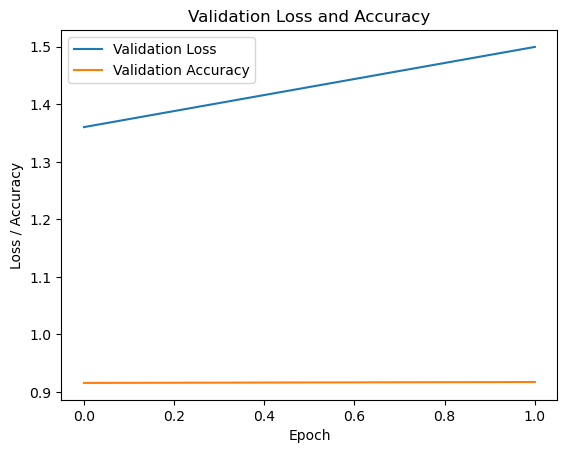

1864/1864 [==============================] - 4s 2ms/step - loss: 1.4997 - accuracy: 0.9172


Accuracy: 91.72%
1864/1864 [==============================] - 3s 2ms/step
Precision: 0.9245
Recall: 0.9172
F1 Score: 0.9206


In [49]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import Callback
from sklearn.metrics import f1_score, precision_score, recall_score

# Custom callback for F1 score, precision, and recall
class MetricsCallback(Callback):
    def __init__(self, validation_data):
        super().__init__()
        self.validation_data = validation_data
        self.f1_scores = []
        self.precision_scores = []
        self.recall_scores = []

    def on_epoch_end(self, epoch, logs=None):
        # Predict on validation data
        y_prob = self.model.predict(self.validation_data[0])
        y_pred = np.argmax(y_prob, axis=1)
        y_true = self.validation_data[1]

        # Calculate metrics
        f1 = f1_score(y_true, y_pred, average='weighted')
        precision = precision_score(y_true, y_pred, average='weighted')
        recall = recall_score(y_true, y_pred, average='weighted')

        # Store metrics
        self.f1_scores.append(f1)
        self.precision_scores.append(precision)
        self.recall_scores.append(recall)

        # Print metrics
        print(f'\nValidation F1 Score: {f1:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}')

# Update the number of classes based on the unique labels
num_classes = len(np.unique(all_labels_encoded))

# Define a Mini-VGGNet simplified model
model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(78, 1, 1), padding='same'))
model.add(MaxPooling2D((2, 2), padding='same'))

model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2), padding='same'))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(num_classes, activation='softmax'))

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Define the MetricsCallback
metrics_callback = MetricsCallback(validation_data=(X_test_reshaped, y_test_encoded))

# Fit the model with the callback
history = model.fit(X_train_reshaped, y_train_encoded, epochs=2, validation_data=(X_test_reshaped, y_test_encoded), callbacks=[metrics_callback])

# Plot Validation Loss and Accuracy
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Validation Loss and Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Loss / Accuracy')
plt.legend()
plt.show()

# Evaluate the model
results = model.evaluate(X_test_reshaped, y_test_encoded)
print("\n\nAccuracy: %.2f%%" % (results[1] * 100))

# Calculate Precision, Recall, and F1 Score
y_prob = model.predict(X_test_reshaped)
y_pred = np.argmax(y_prob, axis=1)
precision = precision_score(y_test_encoded, y_pred, average='weighted')
recall = recall_score(y_test_encoded, y_pred, average='weighted')
f1 = f1_score(y_test_encoded, y_pred, average='weighted')

print("Precision: %.4f" % precision)
print("Recall: %.4f" % recall)
print("F1 Score: %.4f" % f1)
